In [26]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine

2015년부터 5년간 금의 가격과 연관된 정보들을 가져온다.

gap은 그날의 (고가 - 종가) / 시초가 로 변동성을 확인 하기 위한 지표이다.</br>
나머지 지표들은 말 그대로를 의미한다.

In [27]:
df = pd.read_sql("SELECT * FROM GCF_1d",engine) #로컬 db에서 테이블 가져옴
df.set_index(df.columns[0], inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
time,,,,,,,,,,,
2015-11-11,1084.7,0.007,26.963,-7.636,-16.473,1159.433,0.200,0.508,1.502,0.948,-0.322
2015-11-12,1080.8,0.005,25.932,-9.672,-17.816,1159.433,0.081,0.000,1.002,0.946,-0.360
2015-11-13,1080.8,0.005,25.932,-11.470,-18.666,1159.430,0.709,0.000,0.668,0.946,0.000
2015-11-16,1083.7,0.008,28.296,-12.954,-18.887,1159.429,0.500,0.000,0.445,0.947,0.268
2015-11-17,1068.7,0.010,24.024,-14.371,-20.042,1159.428,0.512,3.715,1.535,0.940,-1.384
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,1929.2,0.011,50.111,11.177,5.643,1410.359,0.017,19.291,15.511,1.310,0.526
2022-04-05,1922.9,0.013,48.876,9.791,4.246,1410.380,0.019,6.383,12.468,1.309,-0.327
2022-04-06,1918.4,0.008,47.967,8.382,2.744,1410.387,0.006,2.411,9.116,1.309,-0.234


In [28]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
count,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000,1612.000000
mean,1467.086600,0.009237,52.339631,3.367406,3.396945,1258.025330,0.884953,10.147158,10.131508,1.115498,0.040272
std,264.931027,0.008016,12.321835,12.962989,13.864280,73.993604,1.313577,10.944153,5.559710,0.111306,0.933394
min,1050.800000,0.000000,20.349000,-31.182000,-37.345000,1134.228000,0.000000,0.000000,0.129000,0.929000,-4.979000
25%,1257.200000,0.004000,44.568500,-5.146250,-5.448750,1203.810500,0.132750,1.784500,6.033250,1.033000,-0.384000
50%,1328.050000,0.008000,51.940500,2.138000,2.352000,1242.065000,0.418000,6.814500,9.384000,1.064000,0.049500
75%,1760.125000,0.012000,61.171500,11.176250,11.653000,1317.326250,1.054000,14.909000,13.472500,1.232250,0.524500
max,2051.500000,0.081000,87.904000,54.757000,63.413000,1410.411000,7.000000,77.444000,37.435000,1.343000,5.948000


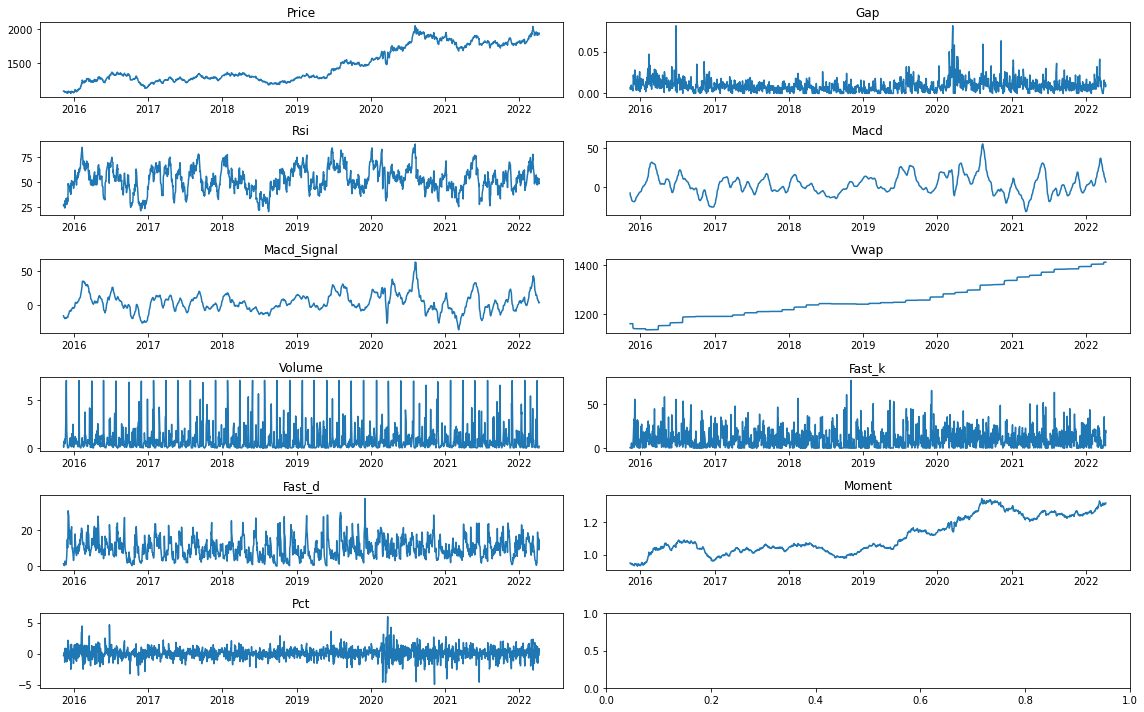

In [29]:
get_rows = lambda x: x // 2 if x % 2 == 0 else x // 2 +1 #행의 수를 결정한다.
rows = get_rows(len(df.columns))
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns, start=1):
        plt.subplot(len(df.columns) // 2 + 1,2,i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

<AxesSubplot:>

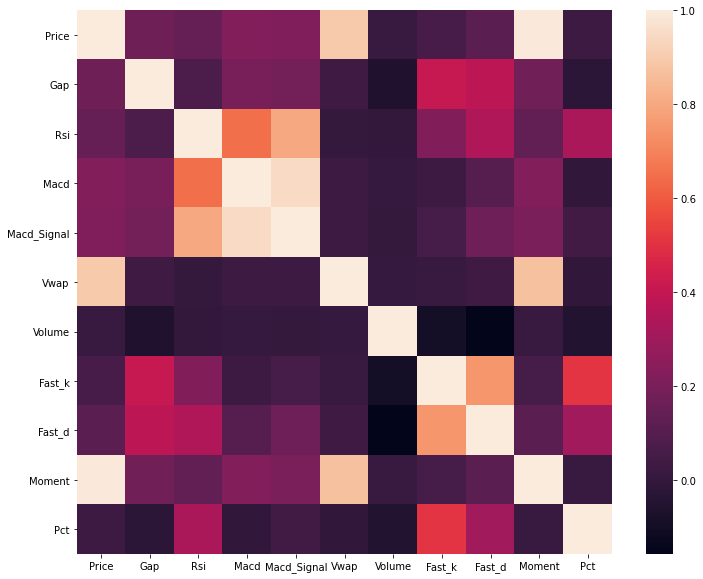

In [30]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr)

In [31]:
corr[corr.abs() > 0.3]

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
Price,1.000000,NaN,NaN,NaN,NaN,0.897398,NaN,NaN,NaN,0.994395,NaN
Gap,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.409112,0.381420,NaN,NaN
Rsi,NaN,NaN,1.000000,0.649181,0.798431,NaN,NaN,NaN,0.347295,NaN,0.332333
Macd,NaN,NaN,0.649181,1.000000,0.948072,NaN,NaN,NaN,NaN,NaN,NaN
Macd_Signal,NaN,NaN,0.798431,0.948072,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Vwap,0.897398,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,0.871255,NaN
Volume,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Fast_k,NaN,0.409112,NaN,NaN,NaN,NaN,NaN,1.000000,0.751106,NaN,0.512064
Fast_d,NaN,0.381420,0.347295,NaN,NaN,NaN,NaN,0.751106,1.000000,NaN,0.304324
Moment,0.994395,NaN,NaN,NaN,NaN,0.871255,NaN,NaN,NaN,1.000000,NaN


pct는 Rsi, Fask_k와 깊은 상관성을 보인다.</br>
price는 vwap와 관련이 깊어 보인다. 

RSI와 가격 증감률 간의 상관 관계를 나타내보면 다음과 같다. </br>
어느 정도의 양의 상관 관계를 갖는 것이 보인다.

In [9]:
def plot_corr(x, y, x_name = 'X_feature', y_name = 'y_feature'):
    plt.figure(figsize=(10,10))
    x = (x - x.min()) / (x.max() - x.min())
    y = (y - y.min()) / (y.max() - y.min())
    plt.scatter(x=x, y=y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

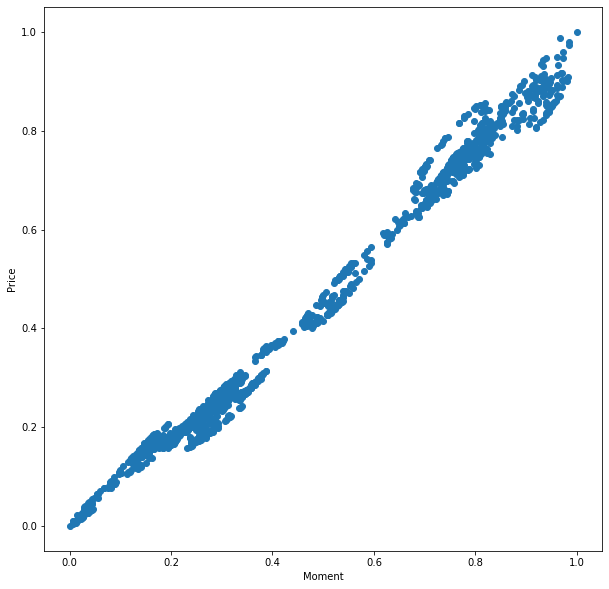

In [32]:
plot_corr(x=df['Moment'], y=df['Price'], x_name="Moment", y_name="Price")

VWAP와 가격의 상관 관계
* 강한 양의 상관 관계를 띄지만 파악이 불가한 부분이 존재한다.

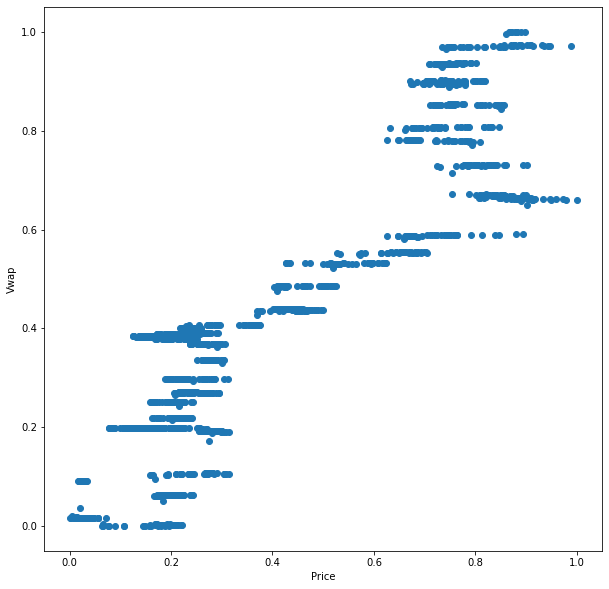

In [33]:
plot_corr(x=df['Price'], y=df['Vwap'], x_name="Price", y_name="Vwap")

#### MACD와 가격 증감률 간의 관계를 살펴보자.

MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


In [34]:
def get_cross(graph1, graph2):
    """ 특정한 그래프 2개를 입력받고 
    그래프가 교차되는 지점을 구해줍니다"""
    gap = graph1 - graph2
    buy_sign = []
    sell_sign = []
    for i, g in enumerate(gap.values[1:], start=1):
        if g * gap[i - 1] < 0:
            if g > 0: #차이가 양으로 전환되면 과매수이므로 매도 시그널이다.
                buy_sign.append(gap.index[i]) 
            else:
                sell_sign.append(gap.index[i])
    return buy_sign, sell_sign

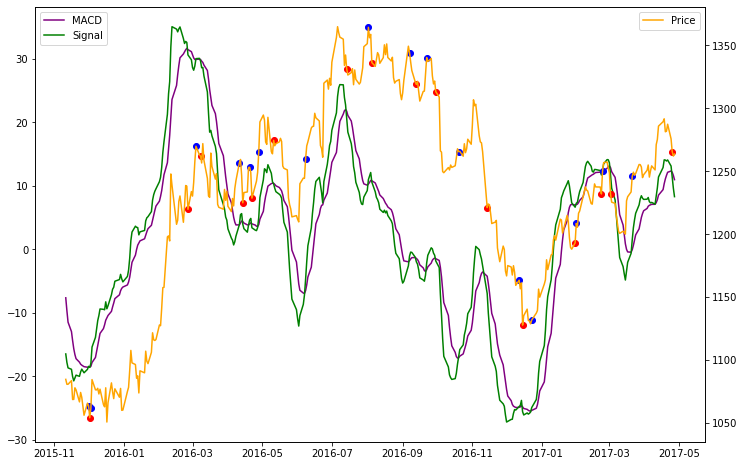

In [35]:
YEAR = 365
fig,ax1 = plt.subplots(figsize=(12,8))
macd_year, signal_year = df['Macd'].iloc[:YEAR], df['Macd_Signal'].iloc[:YEAR]
buy_point, sell_point = get_cross(macd_year, signal_year)
price = df['Price'].iloc[:YEAR]

ax1.plot(macd_year, label='MACD', color='purple')
ax1.plot(signal_year, label='Signal', color='green')
plt.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(price[:500],color='orange',label='Price')
ax2.scatter(buy_point, price.loc[buy_point], marker='o', color='red')
ax2.scatter(sell_point, price.loc[sell_point], marker='o', color='blue')

plt.legend(loc="upper right")

* MACD는 이동평균이라는 정보에 걸맞게 가격의 변동을 원만한 기울기로 추종하고 있다는 것을 확인 할 수 있다. </br>
* Signal과 교차되는 전략을 생각해보면 훌륭하게 들어 맞는다고 볼 수는 없을 것 같다. (빨강: 매수, 파랑: 매도)</br>

* <i>금은 MACD를 활용하는 투자를 가장 사용해볼만한 종목중 하나인데, 재미있는 점은 상승 크로스가 발생할 때마다
가격이 떨어지게 된다. 누군가가 크로스가 발생하려고 할때마다 물건을 대량으로 던진다는 것이다.</i>


* 피쳐의 관점에선 MACD와 MACD 시그널은 실상 같은 움직임을 보이므로</br>
둘중 하나의 피쳐만 사용하는 쪽이 더 나을 듯 하다. </br>
아니면 시그널과 MACD의 격차만을 피쳐로 사용하는 것도 괜찮아 보인다.

#### 스토캐스틱 지표의 상관관계

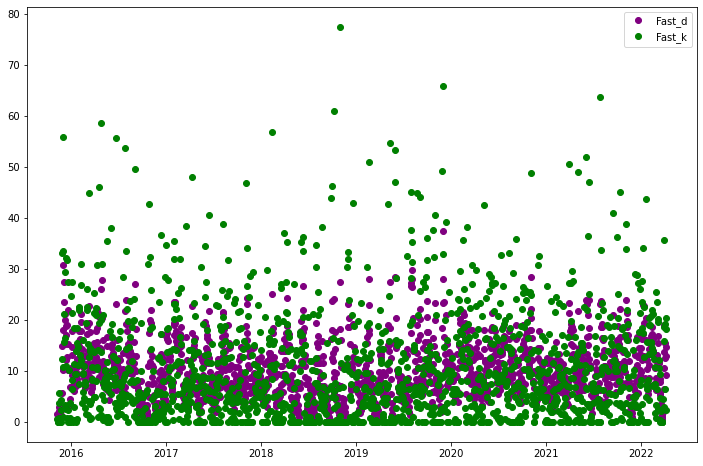

In [36]:
plt.figure(figsize=(12,8))
plt.plot(df['Fast_d'], label='Fast_d', color='purple',linestyle='None',marker='o')
plt.plot(df['Fast_k'], label='Fast_k', color='green',linestyle='None',marker='o')
plt.legend()

Fast_d는 Fast_k를 또 다시 이동평균을 내 활용한 지표이다 보니 값이 전반적으로 안정적이고 극렬하게 튀는 현상이 덜하다.</br>
Fast_k가 가격 증감률과의 상관관계도 더 높지만, 과하게 상태 변화를 받아들이는 값이라는 점에서 </br>
Fast_k보다 Fast_d를 사용하는 쪽이 유리해 보인다.</br>
Fast_k, Fast_d는 상관 계수가 0.7을 넘어가기에 하나만 사용한다.

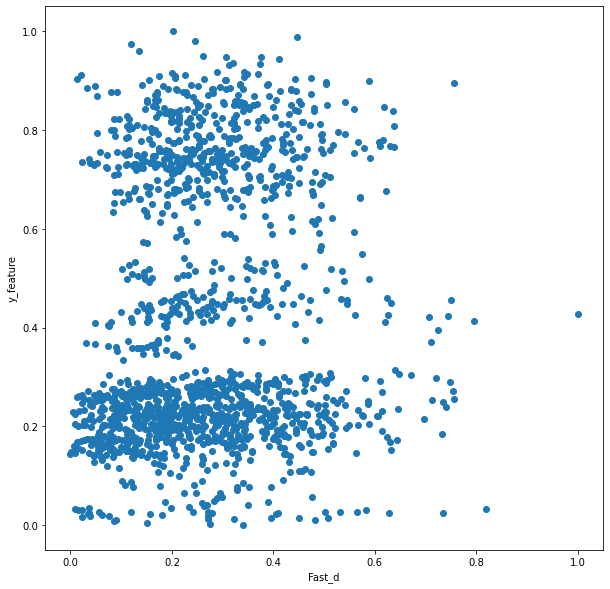

In [37]:
plot_corr(x=df['Fast_d'], y=df['Price'],x_name="Fast_d")

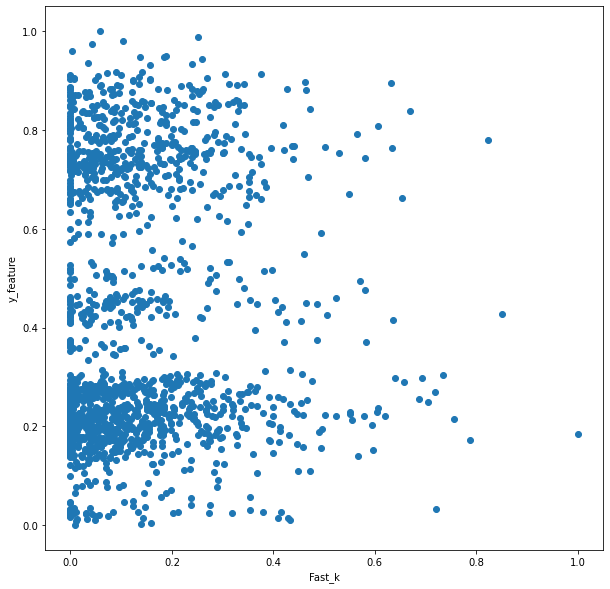

In [38]:
plot_corr(x=df['Fast_k'],y=df['Price'],x_name="Fast_k")

#### 피쳐 선택
다음과 같은 피쳐를 제외하고 모델을 학습 시키기로 했다.
* Gap: 대신 가격 증감률을 사용하기로 했다.
* Macd, Macd_Signal: 대신 시그널 - MACD를 사용한다.
* Fast_k: 대신 Fast_d를 사용한다.

In [39]:
macd_gap = df['Macd_Signal'] - df['Macd']
new_df = df.drop(["Macd","Fast_k"], axis=1)
new_df["Macd_Gap"] = macd_gap
new_df

,Price,Gap,Rsi,Macd_Signal,Vwap,Volume,Fast_d,Moment,Pct,Macd_Gap
time,,,,,,,,,,
2015-11-11,1084.7,0.007,26.963,-16.473,1159.433,0.200,1.502,0.948,-0.322,-8.837
2015-11-12,1080.8,0.005,25.932,-17.816,1159.433,0.081,1.002,0.946,-0.360,-8.144
2015-11-13,1080.8,0.005,25.932,-18.666,1159.430,0.709,0.668,0.946,0.000,-7.196
2015-11-16,1083.7,0.008,28.296,-18.887,1159.429,0.500,0.445,0.947,0.268,-5.933
2015-11-17,1068.7,0.010,24.024,-20.042,1159.428,0.512,1.535,0.940,-1.384,-5.671
...,...,...,...,...,...,...,...,...,...,...
2022-04-04,1929.2,0.011,50.111,5.643,1410.359,0.017,15.511,1.310,0.526,-5.534
2022-04-05,1922.9,0.013,48.876,4.246,1410.380,0.019,12.468,1.309,-0.327,-5.545
2022-04-06,1918.4,0.008,47.967,2.744,1410.387,0.006,9.116,1.309,-0.234,-5.638


#### 모멘텀 지표
* 추가적으로 특정 주기별 비트코인의 기하 평균 수익률을 기록하는 모멘텀 지표를 추가해준다.
* 모멘텀 지표를 통해 추세를 확인 할 수 있다.

In [40]:
def get_profit(X):
    """수익률을 구해준다."""
    seed = [1]
    for i, v in enumerate(X[1:], start=1):
        seed.append(seed[i - 1] * (1 + v))
    return seed

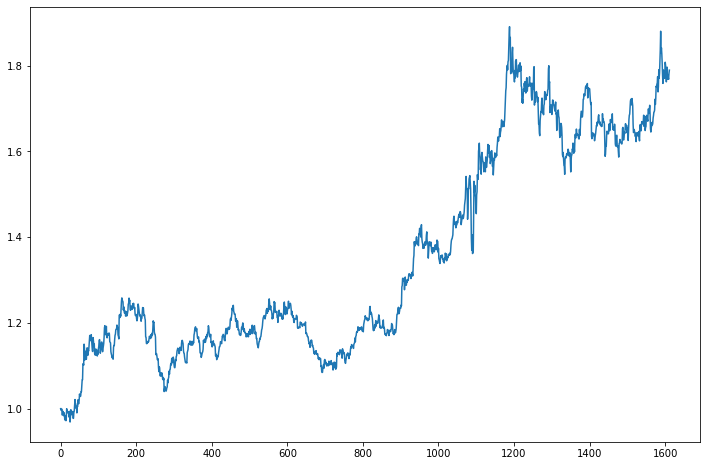

In [41]:
plt.figure(figsize=(12,8))
plt.plot(get_profit(new_df['Pct'] / 100))

In [42]:
#수익 곡선을 그려보자 비트코인 그래프와 흡사하게 그려진다.
#모멘텀 팩터 만들기
profit = pd.Series(index=new_df.index, data=get_profit(new_df['Pct'] / 100)) #profit은 실제 내 수익률을 보여준다.
w2 = profit.rolling(14).apply(lambda x: x.prod() ** (1.0 / 14)) #2주 간의 기하 평균 수익률
m1 = profit / profit.rolling(30).apply(lambda x: x.prod() ** (1.0 / 30)) #1달 간의 기하 평균 수익률
m2 = profit / profit.rolling(60).apply(lambda x: x.prod() ** (1.0 / 60)) #2달 간의 기하 평균 수익률
momentum = (w2 * 0.5 + m1 * 0.3 + m2 * 0.2).dropna()

* 모멘텀 지표는 실제 수익률 그래프와 비교했을 때 평균을 활용하기에 훨씬 부드럽고 </br>
전반적인 추세 파악에 유용하다.

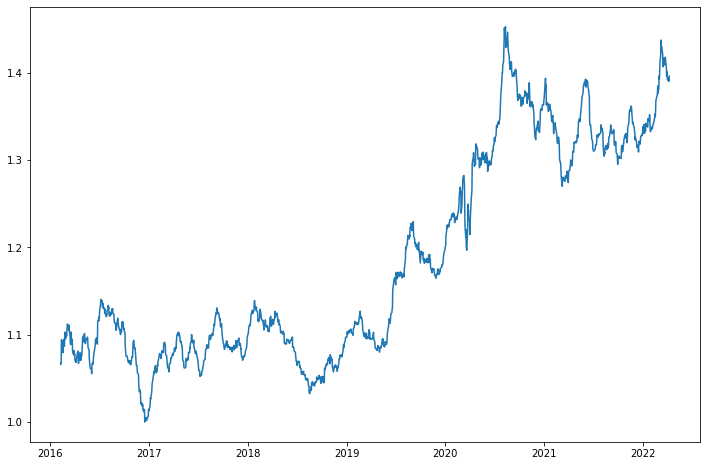

In [43]:
plt.figure(figsize=(12, 8))
plt.plot(momentum)

#### 이상치 확인 해보기
* iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. 
* gap, vwap, macd가 특히 심하다.


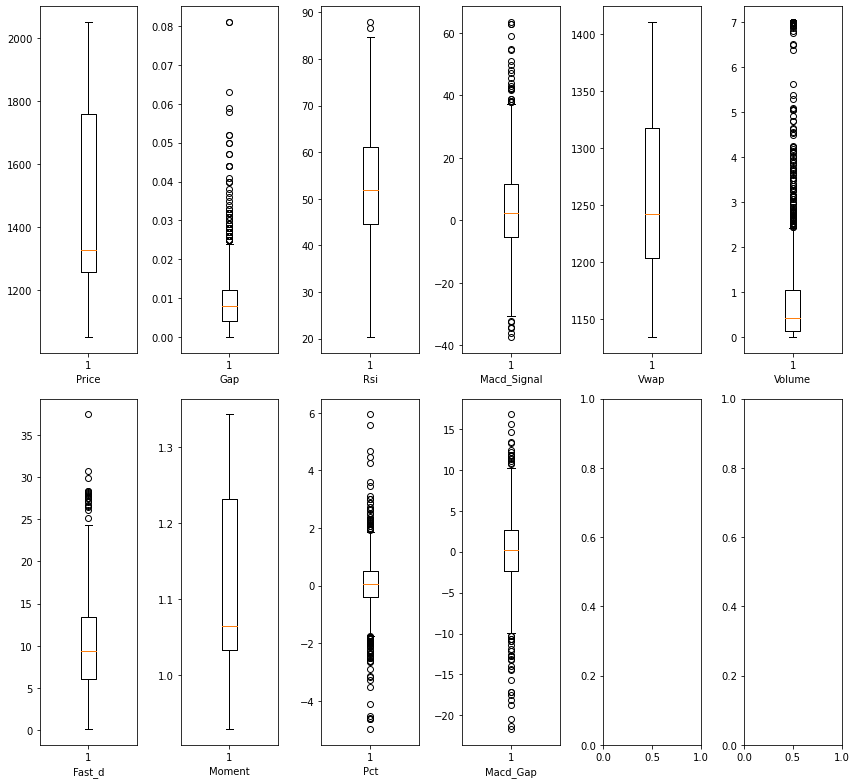

In [44]:
fig,axes = plt.subplots(2,6,figsize=(12,11))
for i, c in enumerate(new_df.columns,start=1):
    plt.subplot(2,6,i)
    plt.boxplot(new_df[c])
    plt.xlabel(c)
plt.tight_layout()

In [45]:
from collections import defaultdict
def get_outliers(df):
    """ 
        iqr 범위를 벗어나는 아웃 라이어들의 인덱스를 반환한다.
    """
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row, col = outliers
    outliers_loc = defaultdict(list)
    for r,c in zip(row,col):
        outliers_loc[df.columns[c]].append(r)
    return outliers_loc


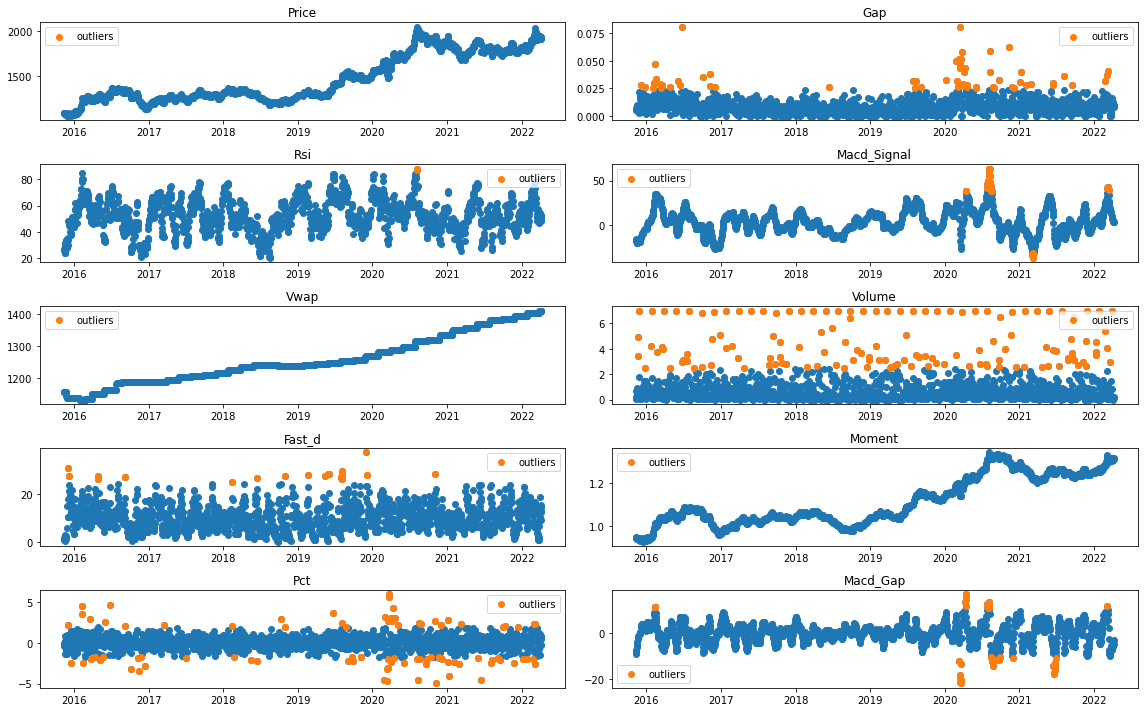

In [46]:
def draw_outlier(outliers_cols, df):
    """ 아웃 라이어들을 피쳐 별로 전부 그려 줍니다"""
    rows = get_rows(len(df.columns))
    fig, axes = plt.subplots(rows, 2, figsize=(16,10))
    for i, c in enumerate(df.columns,start=1):
        index = df[c].index
        plt.subplot(rows,2,i)
        plt.title(c)
        plt.scatter(x=index,y=df[c])
        plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
        plt.legend()
    plt.tight_layout()

outliers_cols = get_outliers(new_df)
draw_outlier(outliers_cols, new_df)

In [47]:
for k, v in outliers_cols.items():
    print(f"{k}: {len(v)}")

Volume: 136
Gap: 65
Fast_d: 20
Pct: 86
Macd_Gap: 41
Macd_Signal: 29
Rsi: 2
Price: 0
Vwap: 0
Moment: 0


<AxesSubplot:>

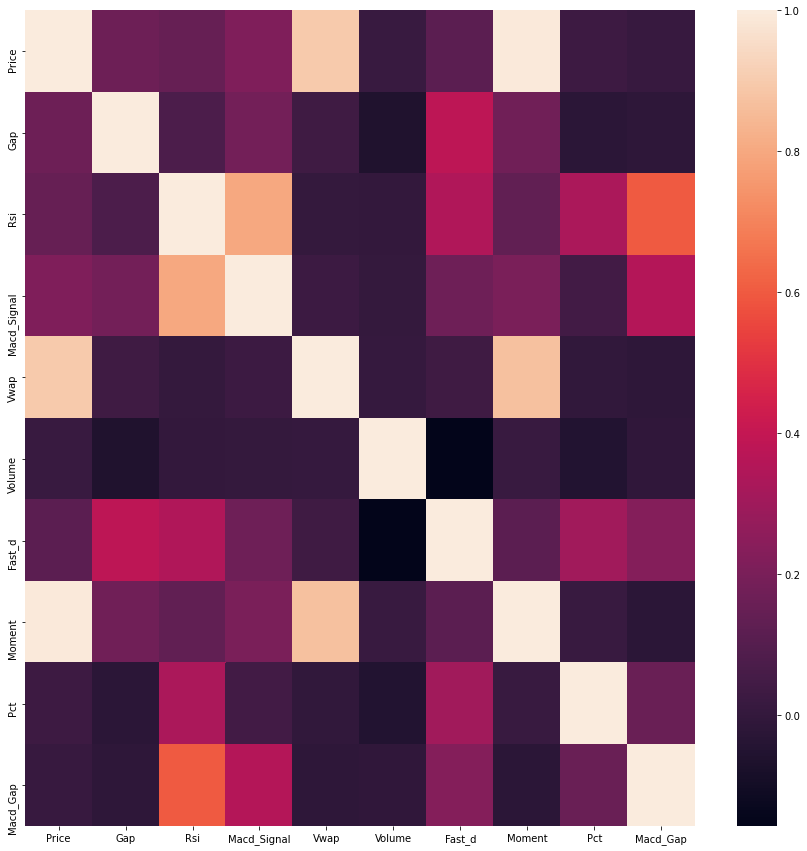

In [48]:
corr = new_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

모멘트 팩터는 큰 연관성은 없어 보이지만, 전반적인 수익률 곡선의 추세를 보여주기에 사용했다.</br>
기존에 존재하는 듀얼 모멘텀 전략 등에서의 아이디어를 활용할 수는 없을까? 라는 가정에서 출발했다.</br>
모멘트 팩터는 실상 조금 완만한 가격 데이터라 해도 과언이 아니다.

모델을 생성하고 비교해보자.

In [49]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max', MinMaxScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max', MinMaxScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=2000))
])

In [50]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['Price'], axis=1).iloc[1:]
    y = df['Price'].iloc[:-1]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [51]:
train_X, test_X, train_y, test_y = create_train_data(new_df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=10, random_state=42))])

In [52]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 52273.24114918173, alpha: 1000
mse: 31411.433572212394, alpha: 300
mse: 12523.43993186773, alpha: 100
mse: 3378.0538064339353, alpha: 30
mse: 1166.9322811915313, alpha: 10
mse: 376.82548811279395, alpha: 1
mse: 68775.8552901206, alpha: 1000
mse: 68775.8552901206, alpha: 300
mse: 68775.8552901206, alpha: 100
mse: 12818.682801186158, alpha: 30
mse: 1961.0144221610458, alpha: 10
mse: 588.924126535756, alpha: 1


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [53]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.3f}')
    plt.legend()

In [54]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar()


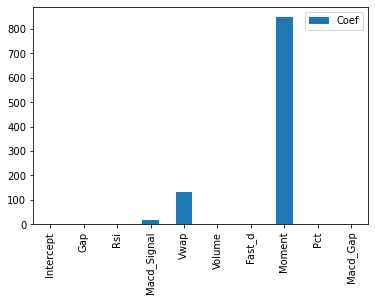

In [55]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns, True)

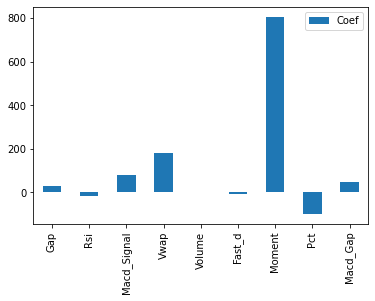

In [56]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)

In [57]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

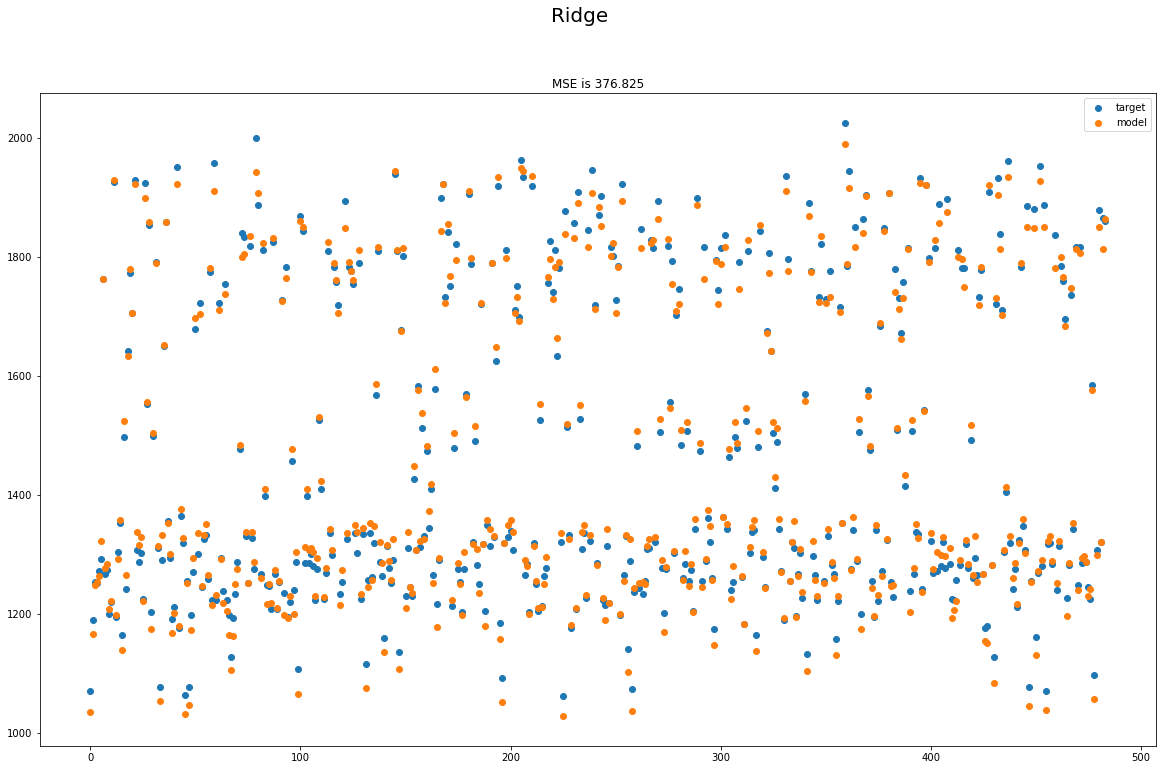

In [58]:
visualize(r_pred, test_y, "Ridge")

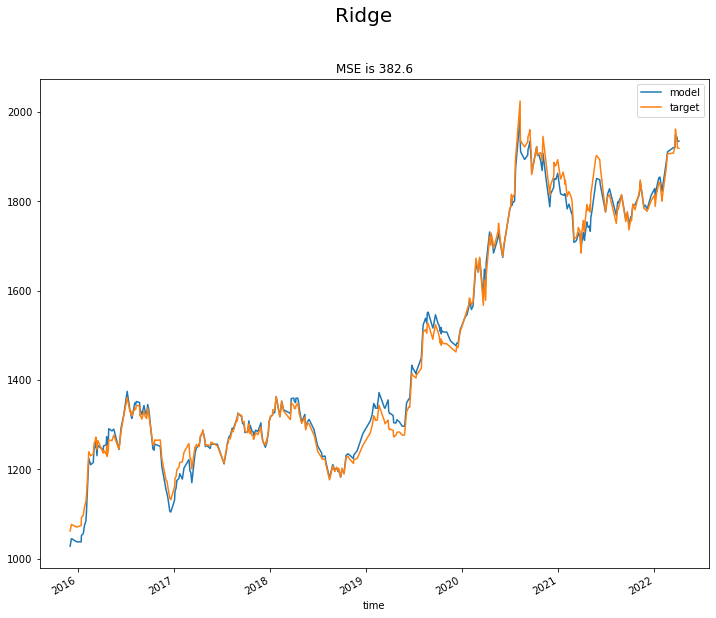

In [59]:
eval_model.visualize_plot(r_pred[-YEAR:], test_y[-YEAR:], "Ridge")


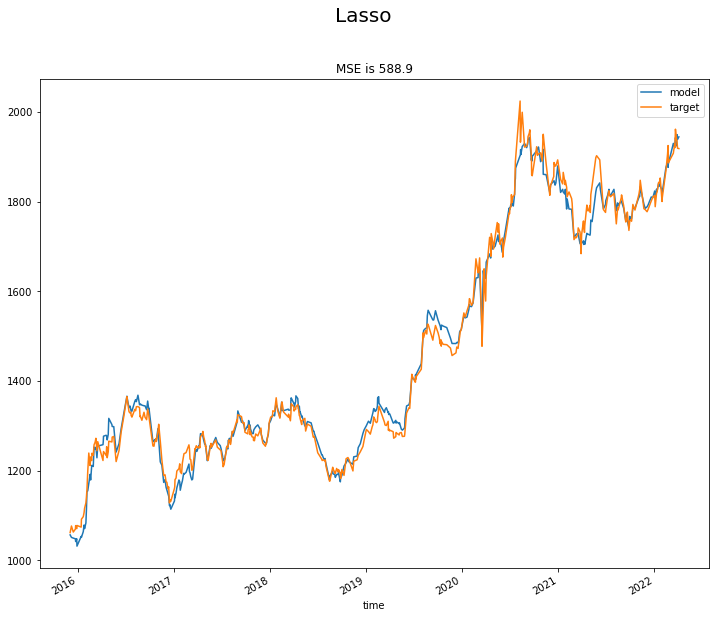

In [60]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")

In [61]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

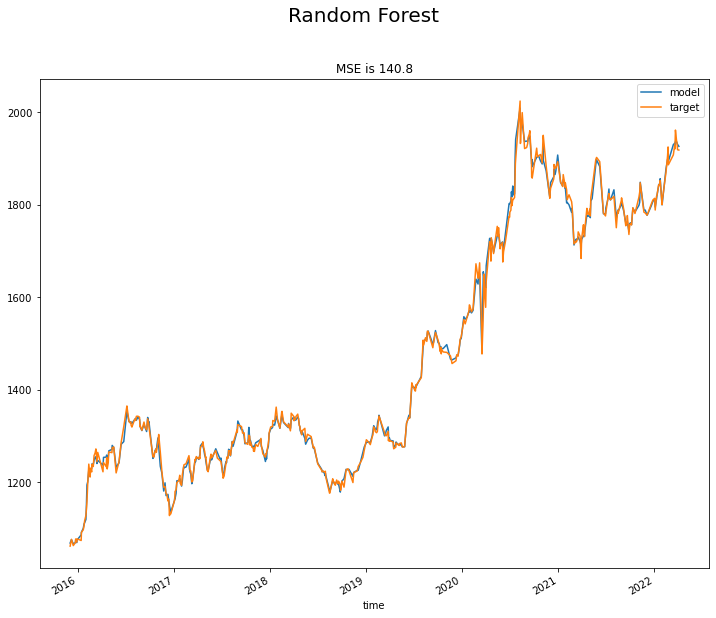

In [62]:
eval_model.visualize_plot(rf_pred, test_y, "Random Forest")

### 모델
* 모델의 성능은 충격적이게도 라쏘가 가장 괜찮은 성능을 보이고 있다. 
* 실상 모맨텀 팩터 하나에만 의지하며 예측을 진행하고 있다.

In [59]:
import joblib
joblib.dump(lasso_model, "Lasso_BTC_only.pkl")
joblib.dump(ridge_model, "Ridge_BTC_only.pkl")

['Ridge_BTC_only.pkl']